In [30]:
import pandas as pd
import numpy as np
from sklearnex.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearnex.svm import SVC
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
# Data Prep
from sklearn.preprocessing import StandardScaler
import warnings

warnings.simplefilter('ignore')

data = pd.read_csv("../Data/cleaned_loan_data.csv", index_col=0)
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=101, stratify=y)
std = StandardScaler().fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

Base learner: SVM, Logistic Regression, Decision Tree, Naive Bayes, K-NN, Perceptron, combine(SVM, Decision Tree, Logistic Regression, Naive Bayes, K-NN, Perceptron [full samples]) <br>
Meta-learner: MLP, SVM, Logistic Regression


1. Combination 1: Logistic Regression, SVM, KNN, Naive Bayes, Decision Tree
2. Combination 2: Logistic Regression, SVM, KNN
3. Combination 3: Logistic Regression, Decision Tree
4. Combination 4: SVM, Naive Bayes, Decision Tree

# Utils

In [31]:
def model_eval(model, X_test, y_test, roc_auc=True, prc=True):
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    
    # Predict the labels
    y_pred = model.predict(X_test)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    if roc_auc is True or precision_recall_curve is True:
        y_pred_proba = model.predict_proba(X_test)
        pos_pred_proba = y_pred_proba[:, 1]
        
        if roc_auc is True:
            dummy_proba = [ 0 for _ in range(len(y_test))]
            dummy_auc = roc_auc_score(y_test, dummy_proba)
            predict_auc = roc_auc_score(y_test, pos_pred_proba)
            print('Baseline: ROC AUC=%.3f' % (dummy_auc))
            print('Model: ROC AUC=%.3f' % (predict_auc))
            # calculate roc curves
            ns_fpr, ns_tpr, _ = roc_curve(y_test, dummy_proba)
            lr_fpr, lr_tpr, _ = roc_curve(y_test, pos_pred_proba)
            # plot the roc curve for the model
            plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
            plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
            # axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # show the legend
            plt.legend()
            plt.title('ROC-AUC Curve')
            # show the plot
            plt.show() 
            
        if prc is True:
            model_precision, model_recall, _ = precision_recall_curve(y_test, pos_pred_proba)
            model_f1, model_auc = f1_score(y_test, y_pred), auc(model_recall, model_precision)
            # summarize scores
            print('Model: f1=%.3f auc=%.3f' % (model_f1, model_auc))
            # plot the precision-recall curves
            baseline = len(y_test[y_test==1]) / len(y_test)
            plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
            plt.plot(model_recall, model_precision, marker='.', label='Model')
            # axis labels
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            # show the legend
            plt.legend()
            plt.title('Precision-Recall Curve')
            # show the plot
            plt.show()
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='all')

    # Display confusion matrix
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm

# Prep

In [36]:
lr = LogisticRegression()
svm = SVC(class_weight='balanced', probability=True)
knn = KNeighborsClassifier(n_neighbors=7)
gnb = GaussianNB()
dt = DecisionTreeClassifier()
base_learners = [lr, svm, knn, gnb, dt]
label_learners = [(lr, 'lr_clf'), (svm, 'svm_clf'), (knn, 'knn_clf'), (gnb, 'gnb_clf'), (dt, 'dt_clf')]
mlp = MLPClassifier()

In [130]:
stack_params = {
    'random_state': 142,
    'use_probas': True,
    'stratify': True,
    'meta_classifier': MLPClassifier(activation='logistic', learning_rate='adaptive', max_iter=250, hidden_layer_sizes=64),
    'store_train_meta_features': True
}

In [131]:
sclf = StackingCVClassifier(classifiers=base_learners, **stack_params)

In [126]:
print('5-fold cross validation:\n')

for clf, label in label_learners:
    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=5, scoring='f1_micro')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.78 (+/- 0.00) [lr_clf]
Accuracy: 0.58 (+/- 0.02) [svm_clf]
Accuracy: 0.76 (+/- 0.01) [knn_clf]
Accuracy: 0.37 (+/- 0.02) [gnb_clf]
Accuracy: 0.72 (+/- 0.01) [dt_clf]


In [127]:
import itertools
for i, j in zip(label_learners, itertools.product([0, 1], repeat=2)):
    print(i, j)

(LogisticRegression(), 'lr_clf') (0, 0)
(SVC(class_weight='balanced', probability=True), 'svm_clf') (0, 1)
(KNeighborsClassifier(n_neighbors=7), 'knn_clf') (1, 0)
(GaussianNB(), 'gnb_clf') (1, 1)


In [132]:
sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[LogisticRegression(),
                                  SVC(class_weight='balanced',
                                      probability=True),
                                  KNeighborsClassifier(n_neighbors=7),
                                  GaussianNB(), DecisionTreeClassifier()],
                     meta_classifier=MLPClassifier(activation='logistic',
                                                   hidden_layer_sizes=64,
                                                   learning_rate='adaptive',
                                                   max_iter=250),
                     random_state=142, store_train_meta_features=True,
                     use_probas=True)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.89      4673
           1       0.68      0.39      0.50      1327

    accuracy                           0.83      6000
   macro avg       0.77      0.67      0.70      6000
weighted avg       0.81      0.83      0.81      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.772


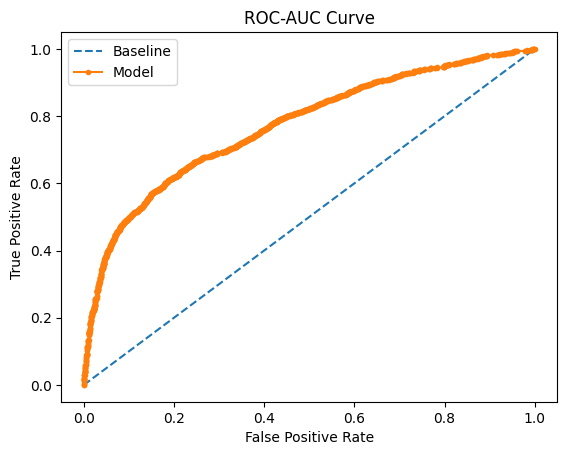

Model: f1=0.499 auc=0.558


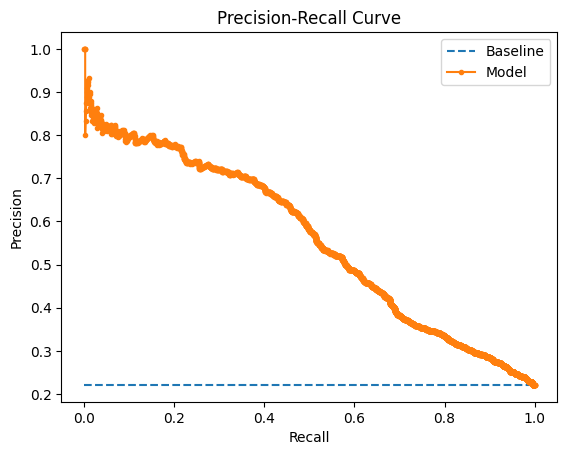

Confusion Matrix:


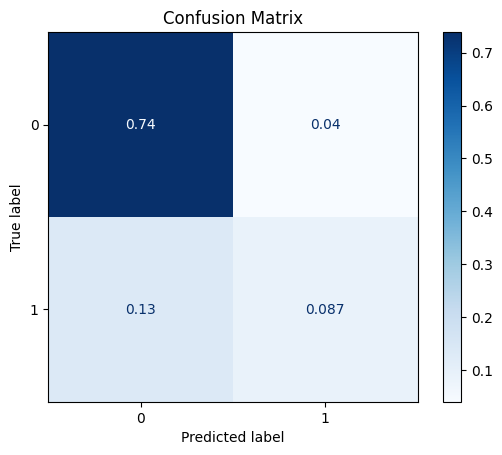

array([[0.73883333, 0.04      ],
       [0.13433333, 0.08683333]])

In [133]:
model_eval(sclf, X_test, y_test)

# Stacking Combinations

## Combination 1: Logistic Regression, SVM, KNN, Naive Bayes, Decision Tree

In [135]:
comb1_base = [lr, svm, knn, gnb, dt]

In [136]:
sclf_1 = StackingCVClassifier(classifiers=comb1_base, **stack_params)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4673
           1       0.67      0.41      0.51      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.67      0.70      6000
weighted avg       0.81      0.82      0.81      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.773


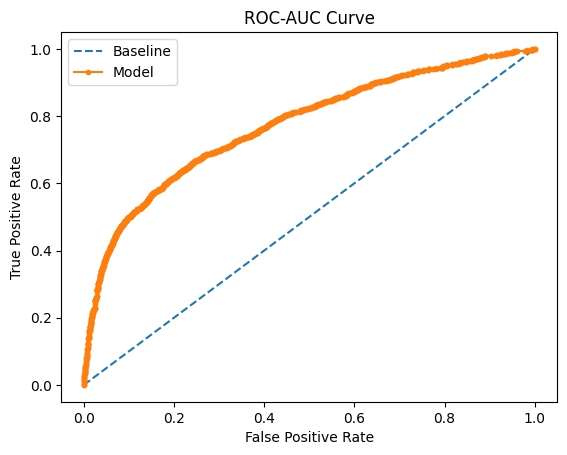

Model: f1=0.505 auc=0.557


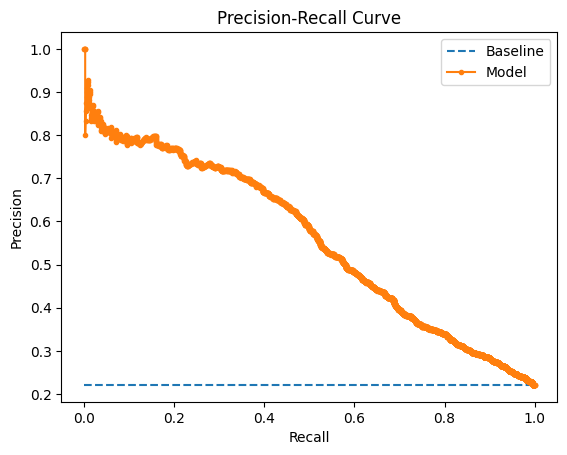

Confusion Matrix:


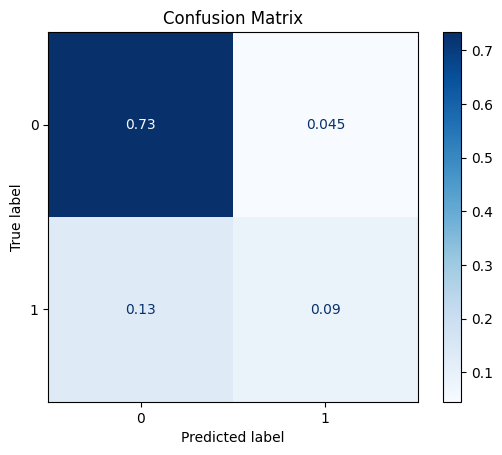

array([[0.73366667, 0.04516667],
       [0.13116667, 0.09      ]])

In [137]:
sclf_1.fit(X_train, y_train)
model_eval(sclf_1, X_test, y_test)

## Combination 2: Logistic Regression, SVM, KNN


In [138]:
comb2_base = [lr, svm, knn]

In [139]:
sclf_2 = StackingCVClassifier(classifiers=comb2_base, **stack_params)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.89      4673
           1       0.68      0.39      0.50      1327

    accuracy                           0.83      6000
   macro avg       0.76      0.67      0.70      6000
weighted avg       0.81      0.83      0.81      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.773


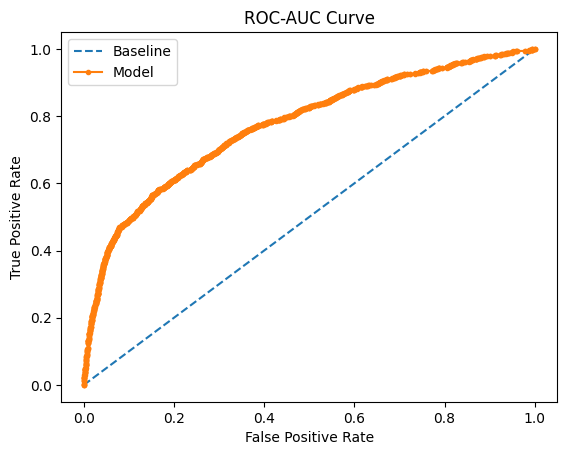

Model: f1=0.500 auc=0.553


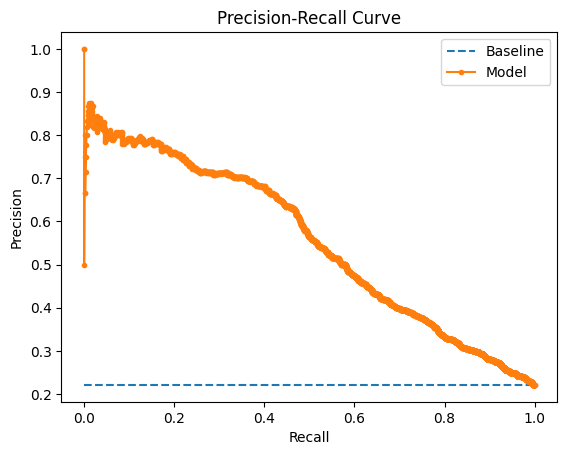

Confusion Matrix:


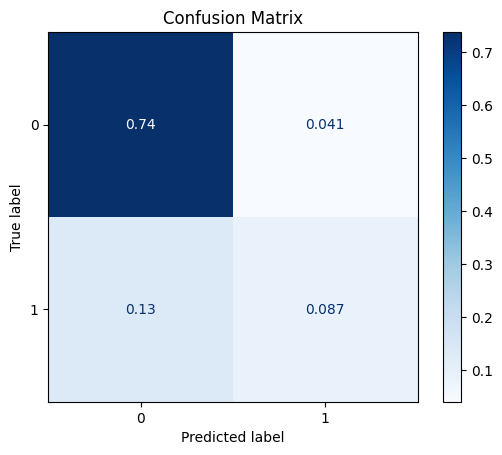

array([[0.73833333, 0.0405    ],
       [0.134     , 0.08716667]])

In [140]:
sclf_2.fit(X_train, y_train)
model_eval(sclf_2, X_test, y_test)

## Combination 3: Logistic Regression, Decision Tree


In [141]:
comb3_base = [lr, dt]

In [142]:
sclf_3 = StackingCVClassifier(classifiers=comb3_base, **stack_params)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.90      4673
           1       0.70      0.37      0.49      1327

    accuracy                           0.83      6000
   macro avg       0.77      0.66      0.69      6000
weighted avg       0.81      0.83      0.80      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.768


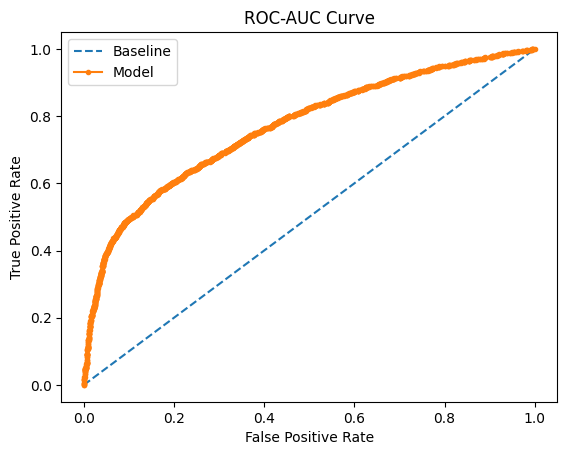

Model: f1=0.487 auc=0.552


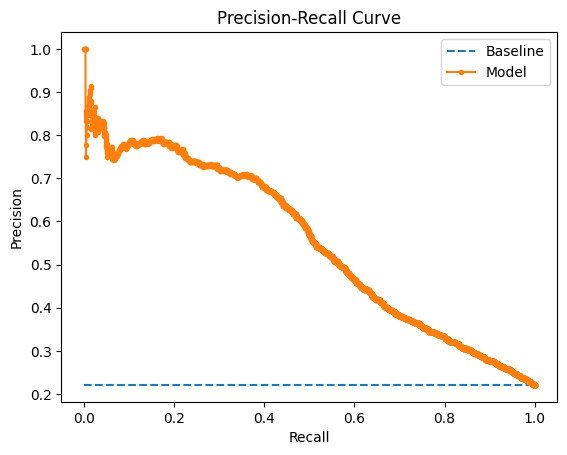

Confusion Matrix:


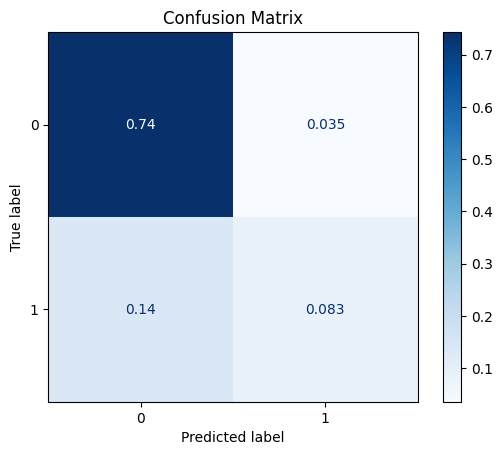

array([[0.74333333, 0.0355    ],
       [0.1385    , 0.08266667]])

In [143]:
sclf_3.fit(X_train, y_train)
model_eval(sclf_3, X_test, y_test)

## Combination 4: SVM, Naive Bayes, Decision Tree


In [144]:
comb4_base = [svm, gnb, dt]

In [145]:
sclf_4 = StackingCVClassifier(classifiers=comb4_base, **stack_params)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      4673
           1       0.62      0.36      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.770


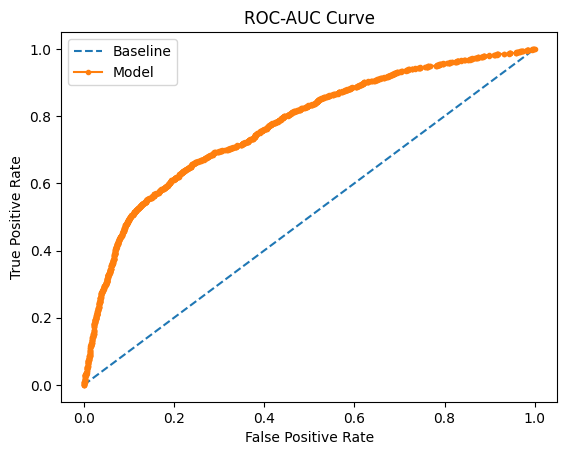

Model: f1=0.453 auc=0.512


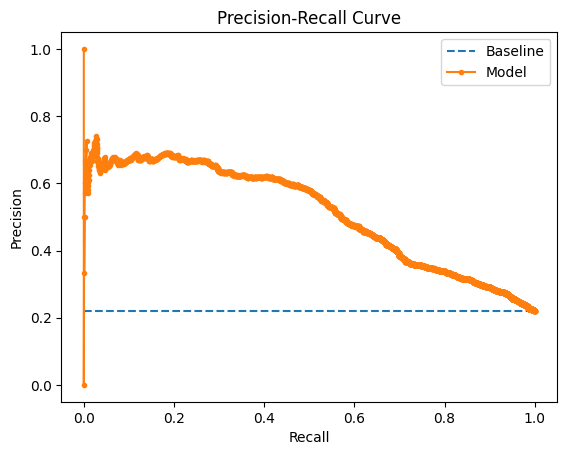

Confusion Matrix:


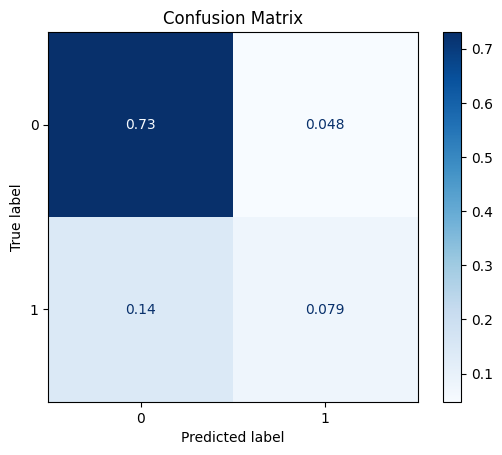

array([[0.73066667, 0.04816667],
       [0.14233333, 0.07883333]])

In [146]:
sclf_4.fit(X_train, y_train)
model_eval(sclf_4, X_test, y_test)

### Aggregated Models

In [175]:
from sklearn.base import clone
stacked_models = [(clone(sclf_1), 'StackedCLF1'), (clone(sclf_2), 'StackedCLF2'), (clone(sclf_3), 'StackedCLF3'), (clone(sclf_4), 'StackedCLF4')]

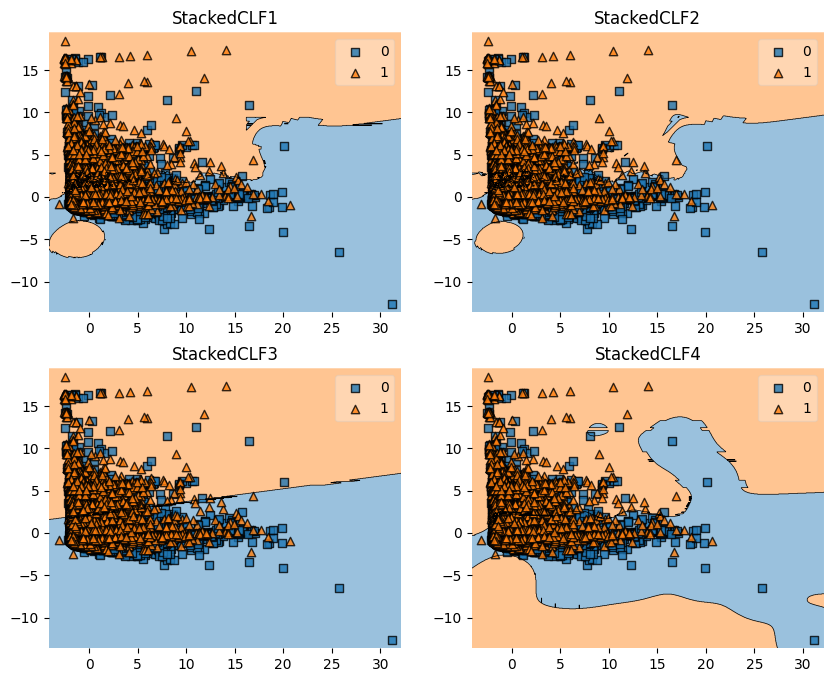

In [176]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import itertools

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for model, grd in zip(stacked_models, itertools.product([0, 1], repeat=2)):
    clf, label = model
    clf.fit(X_pca, y_train.to_numpy())
    ax = plt.subplot(gs[grd[0], grd[1]])
    plot_decision_regions(X=X_pca, y=y_train.to_numpy(), clf=clf, ax=ax)
    plt.title(label)

plt.show()

# Selected Features WOE + Scaled

In [169]:
selected_features = ['LIMIT_BAL','EDUCATION','AGE','PAY_3',
                     'PAY_4','PAY_5','PAY_6','BILL_AMT1',
                     'BILL_AMT2','BILL_AMT4','BILL_AMT5',
                     'BILL_AMT6','PAY_AMT1','PAY_AMT2',
                     'PAY_AMT3','PAY_AMT4', 'PAY_AMT5','PAY_AMT6']

X_woe = data[selected_features]
y_woe = data.iloc[:,-1]

Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_woe, y_woe, train_size=0.8, random_state=142, stratify=y)
std = StandardScaler().fit(Xw_train)
Xw_train = std.transform(Xw_train)
Xw_test = std.transform(Xw_test)



## Combination 1: Logistic Regression, SVM, KNN, Naive Bayes, Decision Tree

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      4673
           1       0.61      0.24      0.34      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.60      0.61      6000
weighted avg       0.77      0.80      0.76      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.727


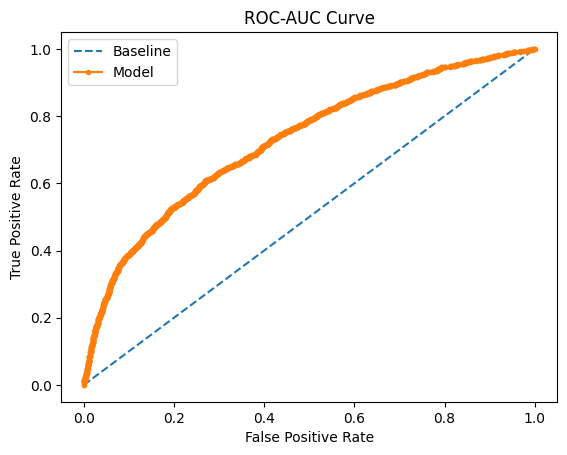

Model: f1=0.345 auc=0.459


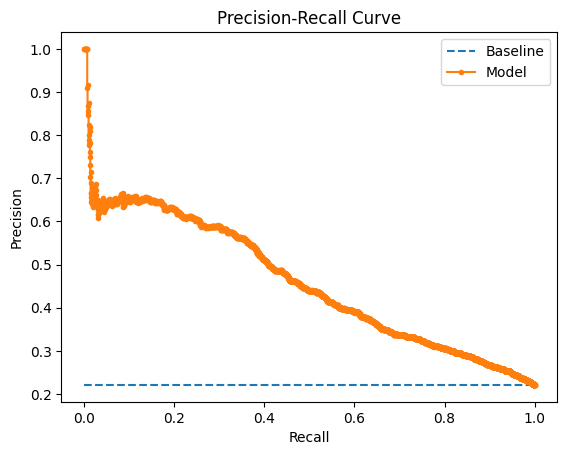

Confusion Matrix:


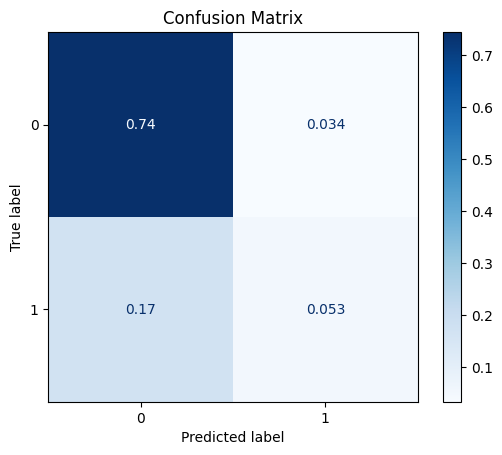

array([[0.74466667, 0.03416667],
       [0.168     , 0.05316667]])

In [170]:
comb1_base = [lr, svm, knn, gnb, dt]
sclfW_1 = StackingCVClassifier(classifiers=comb1_base, **stack_params)
sclfW_1.fit(Xw_train, yw_train)
model_eval(sclfW_1, Xw_test, yw_test)

## Combination 2: Logistic Regression, SVM, KNN

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4673
           1       0.62      0.21      0.32      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.59      0.60      6000
weighted avg       0.77      0.80      0.76      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.725


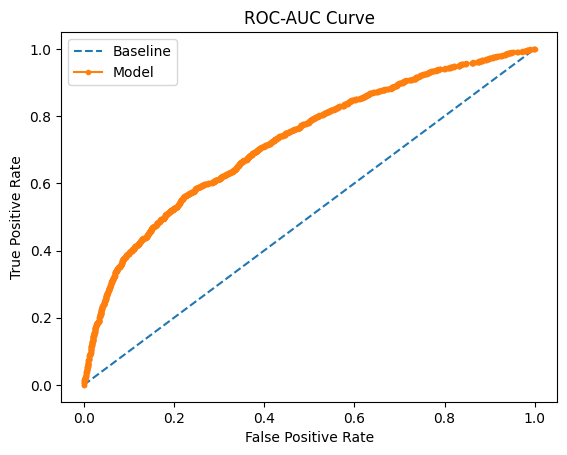

Model: f1=0.316 auc=0.461


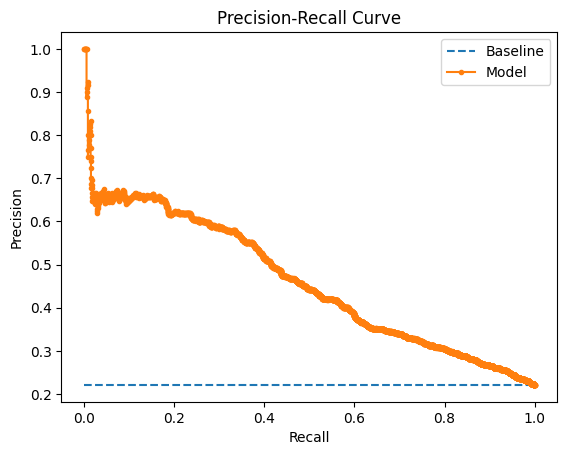

Confusion Matrix:


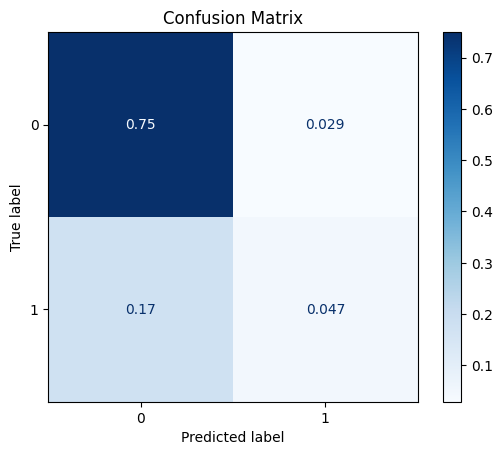

array([[0.74966667, 0.02916667],
       [0.17416667, 0.047     ]])

In [171]:
comb2_base = [lr, svm, knn]
sclfW_2 = StackingCVClassifier(classifiers=comb2_base, **stack_params)
sclfW_2.fit(Xw_train, yw_train)
model_eval(sclfW_2, Xw_test, yw_test)


## Combination 3: Logistic Regression, Decision Tree

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4673
           1       0.61      0.21      0.31      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.59      0.60      6000
weighted avg       0.77      0.80      0.75      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.721


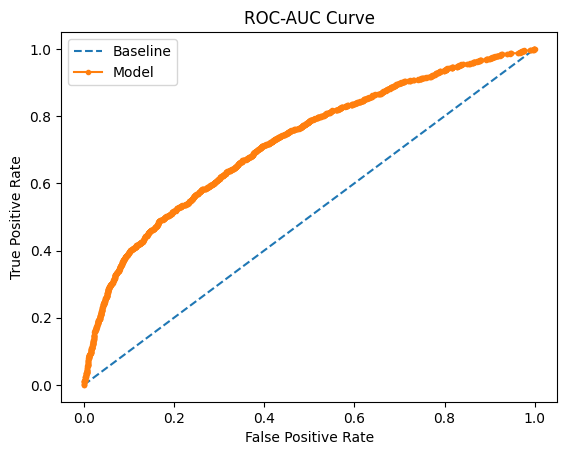

Model: f1=0.313 auc=0.455


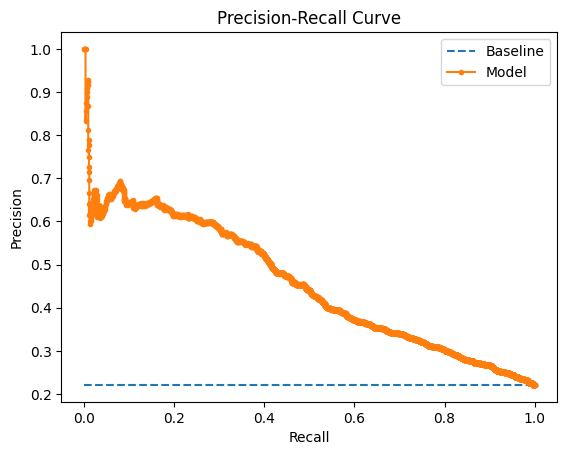

Confusion Matrix:


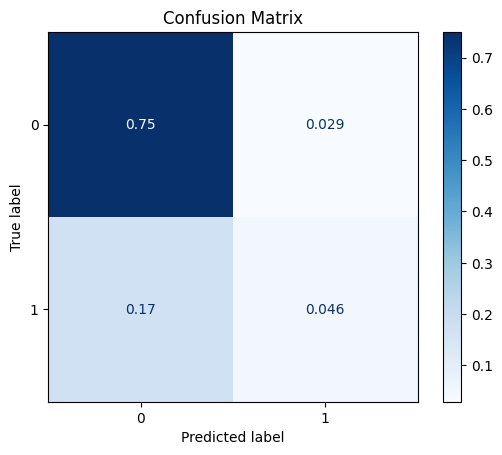

array([[0.74966667, 0.02916667],
       [0.17466667, 0.0465    ]])

In [172]:
comb3_base = [lr, dt]
sclfW_3 = StackingCVClassifier(classifiers=comb3_base, **stack_params)
sclfW_3.fit(Xw_train, yw_train)
model_eval(sclfW_3, Xw_test, yw_test)

## Combination 4: SVM, Naive Bayes, Decision Tree


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      4673
           1       0.50      0.22      0.31      1327

    accuracy                           0.78      6000
   macro avg       0.65      0.58      0.59      6000
weighted avg       0.74      0.78      0.74      6000

Baseline: ROC AUC=0.500
Model: ROC AUC=0.726


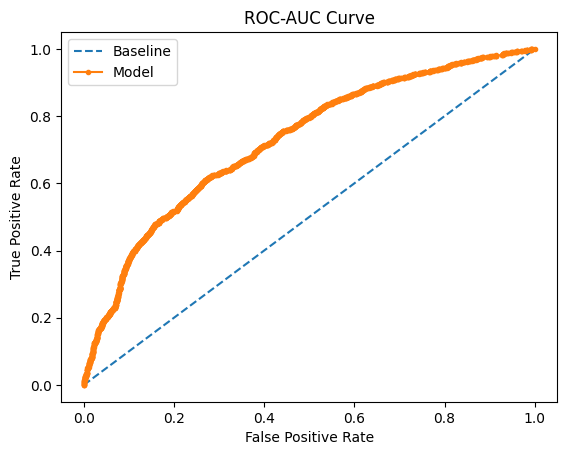

Model: f1=0.308 auc=0.433


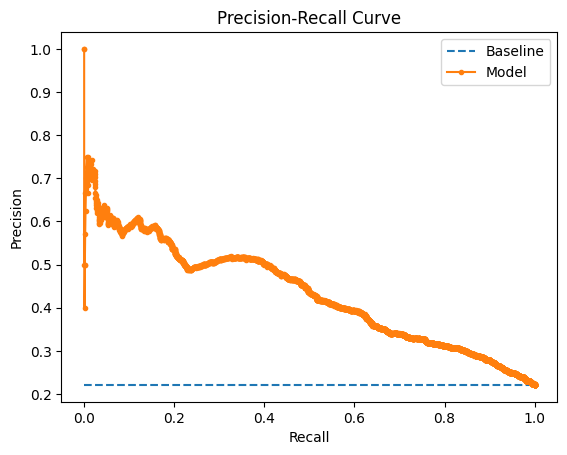

Confusion Matrix:


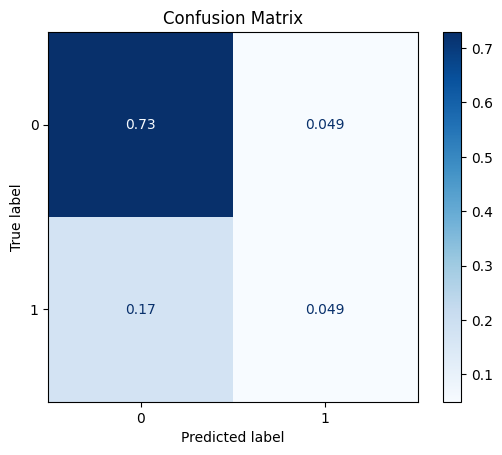

array([[0.7295    , 0.04933333],
       [0.17183333, 0.04933333]])

In [173]:
comb4_base = [svm, gnb, dt]
sclfW_4 = StackingCVClassifier(classifiers=comb4_base, **stack_params)
sclfW_4.fit(Xw_train, yw_train)
model_eval(sclfW_4, Xw_test, yw_test)


### Aggregated Models


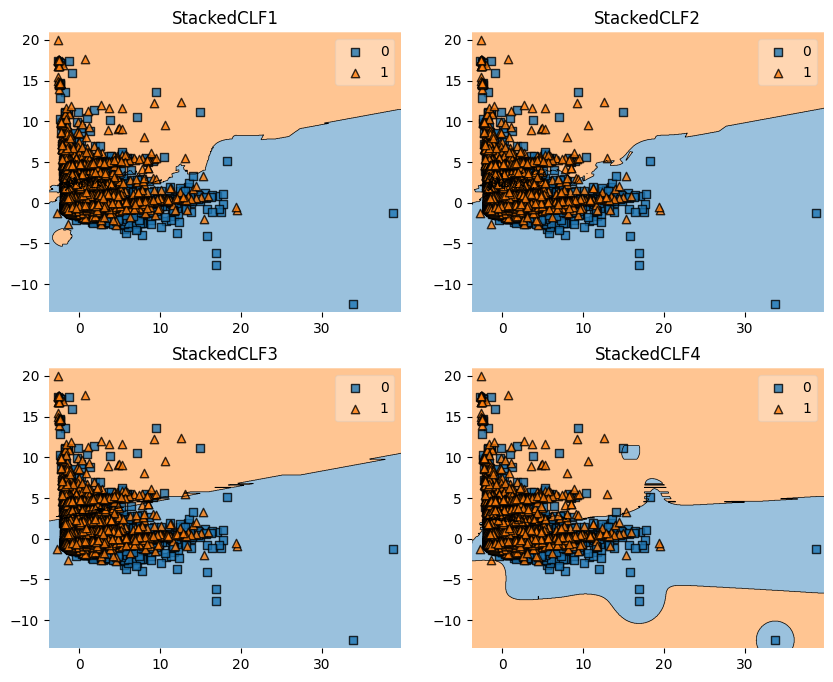

In [177]:
from sklearn.base import clone

stacked_models = [(clone(sclfW_1), 'StackedCLF1'), (clone(sclfW_2), 'StackedCLF2'), (clone(sclfW_3), 'StackedCLF3'),
                  (clone(sclfW_4), 'StackedCLF4')]
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import itertools

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
Xw_pca = pca.fit_transform(Xw_train)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for model, grd in zip(stacked_models, itertools.product([0, 1], repeat=2)):
    clf, label = model
    clf.fit(Xw_pca, yw_train.to_numpy())
    ax = plt.subplot(gs[grd[0], grd[1]])
    plot_decision_regions(X=Xw_pca, y=yw_train.to_numpy(), clf=clf, ax=ax)
    plt.title(label)

plt.show()